In [1]:
import pandas as pd
df = pd.read_csv('tweets.csv', header=None)
df.columns = ['sentiment','text']
df.head()

,sentiment,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 2 columns):
sentiment    498 non-null int64
text         498 non-null object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124024438>]],
      dtype=object)

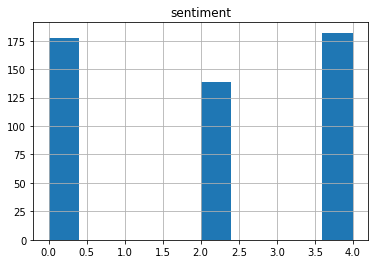

In [3]:
df.hist()

In [4]:
pos_tweets = df.loc[df['sentiment']==4,'text']
neg_tweets = df.loc[df['sentiment']==0,'text']

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xnicolovici/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
stopwords_english = stopwords.words('english')
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

def clean_tweets(tweet):

    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/[^\s]+', '', tweet)

    # remove hashtags
    tweet = re.sub(r'#', '', tweet)


    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
            word not in emoticons and # remove emoticons
            word not in string.punctuation): # remove punctuation
            tweets_clean.append(word)   
    return tweets_clean

In [10]:
sample = pos_tweets.iloc[4]
sample
#"@mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)"

clean_tweets(sample)
#['fair', 'enough', 'kindle', '2', 'think', 'perfect']

['fair', 'enough', 'kindle', '2', 'think', 'perfect']

In [11]:
def bag_of_words(tweet):
    words = clean_tweets(tweet)
    words_dictionary = dict([word, True] for word in words)    
    return words_dictionary

In [12]:
# positive tweets feature set
pos_tweets_set = []
for tweet in pos_tweets:
    pos_tweets_set.append((bag_of_words(tweet), 'pos'))    

#negative tweets feature set
neg_tweets_set = []
for tweet in neg_tweets:
    neg_tweets_set.append((bag_of_words(tweet), 'neg'))

tweets = pos_tweets_set + neg_tweets_set 


In [14]:
from random import shuffle 
shuffle(pos_tweets_set)
shuffle(neg_tweets_set)

test_set = pos_tweets_set[:36] + neg_tweets_set[:36]
train_set = pos_tweets_set[36:] + neg_tweets_set[36:]

In [15]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_set)

In [16]:
accuracy = classify.accuracy(classifier, test_set)

In [17]:
accuracy

0.8194444444444444

In [18]:
classifier.show_most_informative_features(10) 

Most Informative Features
                       2 = True              pos : neg    =     10.6 : 1.0
                  kindle = True              pos : neg    =      7.4 : 1.0
                    hate = True              neg : pos    =      7.2 : 1.0
                 awesome = True              pos : neg    =      6.8 : 1.0
                    time = True              neg : pos    =      6.3 : 1.0
                   great = True              pos : neg    =      5.2 : 1.0
                     one = True              pos : neg    =      4.8 : 1.0
                    love = True              pos : neg    =      4.6 : 1.0
                     api = True              neg : pos    =      4.5 : 1.0
                   phone = True              neg : pos    =      4.5 : 1.0


In [19]:
from collections import defaultdict
from nltk.metrics import ConfusionMatrix

actual_set = defaultdict(set)
predicted_set = defaultdict(set)

actual_set_cm = []
predicted_set_cm = []

for index, (feature, actual_label) in enumerate(test_set):
    actual_set[actual_label].add(index)
    actual_set_cm.append(actual_label)

    predicted_label = classifier.classify(feature)

    predicted_set[predicted_label].add(index)
    predicted_set_cm.append(predicted_label)

print(ConfusionMatrix(actual_set_cm, predicted_set_cm))  

    |  n  p |
    |  e  o |
    |  g  s |
----+-------+
neg |<28> 8 |
pos |  5<31>|
----+-------+
(row = reference; col = test)

